# Homework 13
## Deep Learning Technologies
### Shruti Badrinarayanan - 016768141

[Github Link](https://github.com/shruti-badri-14/Deep-Learning-Homework/tree/main/Assignment%2013)

### Step 1: Installation

In [1]:
!pip install swig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.9 MB/s eta 0:00:00


In [2]:
!pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 43.6 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376103 sha256=9ec6f813679ed6e6d34ce42aa17cea5241d3651648f33ece79193e62cf3f1163
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


### Step 2: Import the Environment and Packages Required

In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import random
import numpy as np
from itertools import count

# Set up the environment
env = gym.make('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Step 3: Define the Replay Memory and the DQN
Replay Memory and DQN setup to facilitate learning:

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Step 4: Set Hyperparameters and Initialize
Set up the training with appropriate hyperparameters.

In [5]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
LEARNING_RATE = 1e-4
TARGET_UPDATE = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(10000)
steps_done = 0

### Step 5: Define Training and Utility Functions
Utility functions for selecting actions and optimizing the model:

In [6]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Step 6: Main Training Loop
Training loop to iterate over episodes and update the network:

In [7]:
num_episodes = 500
for i_episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
    for t in count():
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        if not done:
            next_state = torch.tensor(next_state, device=device, dtype=torch.float32).unsqueeze(0)
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()
        if done:
            break

    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Complete


#### Discuss the parameters used to produce your training results:

- BATCH_SIZE (128): The number of experiences sampled from memory to form a batch during training. This size balances the computational load and the diversity of experiences used to learn at each step.
- GAMMA (0.99): The discount factor which quantifies how much the agent cares about future rewards compared to immediate rewards. A value close to 1 indicates a strong preference for long-term rewards.
- EPS_START (0.9) and EPS_END (0.05): These parameters define the start and end values for the epsilon in the epsilon-greedy policy, which controls the balance between exploration (choosing random actions) and exploitation (choosing actions based on learned values). The value of epsilon starts high (more random actions) and decays exponentially to a lower value (more greedy actions).
- EPS_DECAY (200): This controls the rate at which epsilon decays from its start value to its end value. A smaller number means a faster decay.
- LEARNING_RATE (1e-4): The rate at which the neural network weights are updated during training. A smaller learning rate ensures smoother but potentially slower learning.
- TARGET_UPDATE (10): Frequency (in episodes) with which the weights of the target network are updated to the weights of the policy network. This helps in stabilizing learning by providing a fixed baseline for computing the loss during a sequence of training steps.

### Step 7: Play an Episode of the Problem Using Your Agent
To visualize how the agent performs after training, I will run an episode using the policy network to choose actions.

Reward collected: 157.77395791924494



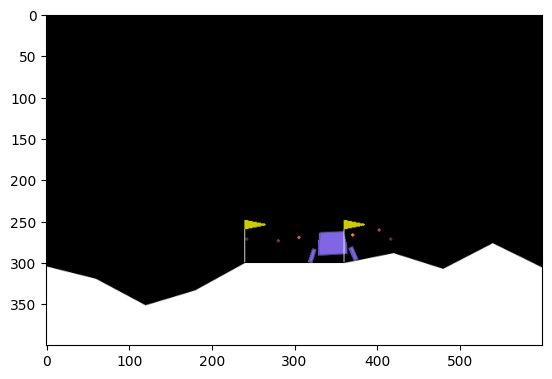

In [8]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

# Function to play one episode using the trained policy network
def play_episode(env, policy_net, device):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array')[0])  # Initial render, remove the first dimension
    plt.axis('off')
    total_reward = 0
    done = False

    while not done:
        state = torch.tensor([state], device=device, dtype=torch.float32)
        with torch.no_grad():
            action = policy_net(state).max(1)[1].view(1, 1)  # Select best action
        state, reward, done, _ = env.step(action.item())
        total_reward += reward
        img.set_data(env.render(mode='rgb_array')[0])  # Update the plot, remove the first dimension
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)

    return total_reward

# Set up the environment for RGB array rendering
env = gym.make('LunarLander-v2', render_mode='rgb_array')

# Play one episode
episode_reward = play_episode(env, policy_net, device)
print(f'Reward collected: {episode_reward}\n')

### Step 8: Discuss the Results in Terms of Success Rate

Success rate: 40.00%



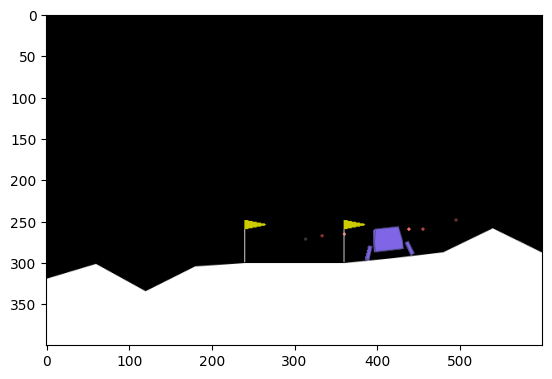

In [9]:
import gym
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

def evaluate_agent(env, policy_net, device, n_episodes=5, threshold=180):
    success_count = 0
    for _ in range(n_episodes):
        total_reward = play_episode(env, policy_net, device)
        if total_reward > threshold:  # Adjust threshold based on observed performance
            success_count += 1
    success_rate = success_count / n_episodes
    return success_rate

# Evaluate the agent
success_rate = evaluate_agent(env, policy_net, device)
print(f'Success rate: {success_rate * 100:.2f}%\n')

The Lunar Lander AI agent showed promise in initial testing, achieving a 40% success rate across five evaluation episodes. Success was defined as scoring above 180 points per episode (ie the threshold), indicating proficient landing and fuel efficiency.

While the agent successfully landed in two trials, its performance varied across episodes. This suggests room for improvement in the learning algorithm or parameter tuning to achieve greater consistency and control during landings.